# Homework 3 (Muhammad Khalid)

In [88]:
import pandas as pd
import numpy as np

## Question 1

For this question, I decided to focus on keywords. These include a subset of commonly found [keywords](https://www.activecampaign.com/blog/spam-words) as well as words I manually saw in the spam messages. I looked at  the proportion of characters that are numbers, length, special symbols, punctuation, links, currency, etc. A lot of this was using regex.

I didn't need to apply any preprocessing since I decided to use RandomForestClassifier in a Grid search. I used a random forest method here because it seemed like a better choice than a decision tree which was my first choice. After I introduced features to the point where I didn't see any improvement, I switched over to random forest. 

In [89]:
import re
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV

raw_data = pd.read_table("https://remiller1450.github.io/data/sms_spam.txt", header=None)
sms = pd.DataFrame({"label": raw_data.iloc[:,0], "email": raw_data.iloc[:,1]})

def count_num_chars(input_text):
    total_chars_per_sentence = input_text.str.len()
    numeric_chars = input_text.str.count(r'\d')
    return numeric_chars/total_chars_per_sentence

def count_currency(text):
    return text.str.count(r'£|\$|€')
def count_keywords(text):
    return (text.str.count(r'\bfree\b', flags=re.IGNORECASE) + 
    text.str.count(r'\bguaranteed\b', flags=re.IGNORECASE) + 
    text.str.count(r'\bwon\b', flags=re.IGNORECASE) +  
    text.str.count(r'\bclick\b', flags=re.IGNORECASE) + 
    text.str.count(r'\boffer\b', flags=re.IGNORECASE) + 
    text.str.count(r'\burgent\b', flags=re.IGNORECASE) + 
    text.str.count(r'\bbonus\b', flags=re.IGNORECASE) + 
    text.str.count(r'\bnow\b', flags=re.IGNORECASE) + 
    text.str.count(r'\bclaim\b', flags=re.IGNORECASE) + 
    text.str.count(r'\bprize\b', flags=re.IGNORECASE) +
    text.str.count(r'\bstop\b', flags=re.IGNORECASE) +
    text.str.count(r'\bwww\b', flags=re.IGNORECASE) +
    text.str.count(r'\bentry\b', flags=re.IGNORECASE) +
    text.str.count(r'\bmsg\b', flags=re.IGNORECASE))

def count_chars(input_text):
    return len(str(input_text))

def count_punct(input_text):
    return input_text.str.count(r'[.,!?;:(){}\[\]<>\—]')

def uppercase_word_ratio(text):
    return text.apply(lambda x: 
        np.mean([w.isupper() for w in x.split()]) if len(x.split()) > 0 else 0)
sms_features = pd.DataFrame()
sms_features['label'] = sms['label']
sms_features['count_keywords'] = count_keywords(sms['email'])
sms_features['word_count'] = sms['email'].str.split().apply(len).replace(0, 1)
sms_features['keyword_ratio'] = sms_features['count_keywords'] / sms_features['word_count']
sms_features['count_num_chars'] = count_num_chars(sms['email']) # important feature
sms_features['repeated_char_count'] = sms['email'].str.count(r'(.)\1{2,}')
sms_features["num_long_words"] = sms["email"].str.count(r"\b\w{10,}\b")
sms_features['avg_word_len'] = sms['email'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split())>0 else 0)
sms_features['contains_link'] = sms['email'].str.contains(r'http|www|\.com', case=False).astype(int)
sms_features['num_upper'] = sms['email'].apply(lambda x: sum(1 for c in x if c.isupper()))
sms_features['count_punct'] = count_punct(sms['email'])
sms_features['count_currency'] = count_currency(sms['email'])
sms_features['uppercase_word_ratio'] = uppercase_word_ratio(sms['email'])

sms_features['label'] = sms_features['label'].replace({'spam': 1, 'ham': 0})

In [90]:
from sklearn.ensemble import RandomForestClassifier


sms_X = sms_features.drop('label', axis=1)
sms_y = sms_features['label']


param_grid = {
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
pipe = Pipeline([
    ('model', RandomForestClassifier(min_samples_split=2, min_samples_leaf=1, n_estimators=200, random_state=42, max_depth=20))
])


grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=5)
grid.fit(sms_X, sms_y)

print("Best estimator:", grid.best_estimator_)
print("Best cross-validated F1 score:", grid.best_score_)

Best estimator: Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=20, min_samples_split=5,
                                        n_estimators=200, random_state=42))])
Best cross-validated F1 score: 0.9557462536696594


## Question 2

My modeling philosophy for this followed a scatterplot approach to feature engineering. I created 6 scatterplots where each scatterplot represented a single feature. I repeated this twice: once for min/max on the x and y axis for the respective variable and again from mean/std deviation. Overall, the scatterplots seemed to show slightly better separation between the two target classes for the mean/std deviation plots. To verify, I ran a random forest classifier with `f1` as the scoring metric and found that the mean/std deviation approach indeed improved the score.

I chose to use a random forest approach because some of the features had a non-linear relationship between their means and standard deviations. This approach also allowed me to handle correlated and differently scaled features.

In [91]:
dd = pd.read_csv("https://remiller1450.github.io/data/drugdetection.csv")

Full_Sample_ID
CFS.Brake.Pedal.Force


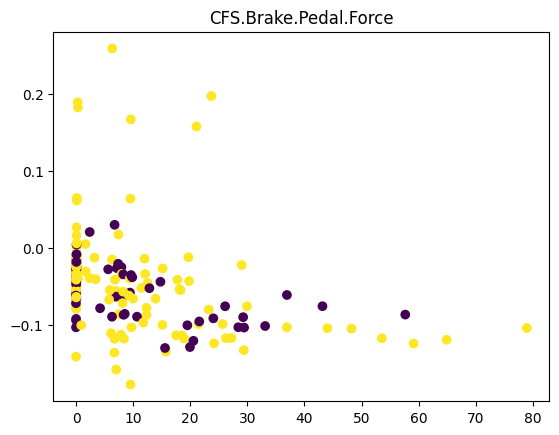

CFS.Accelerator.Pedal.Position


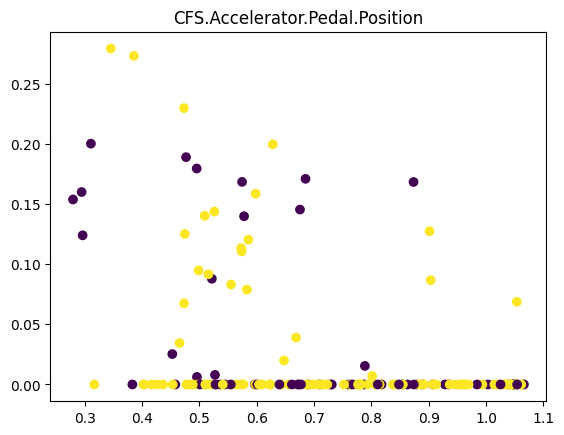

CFS.Steering.Wheel.Angle


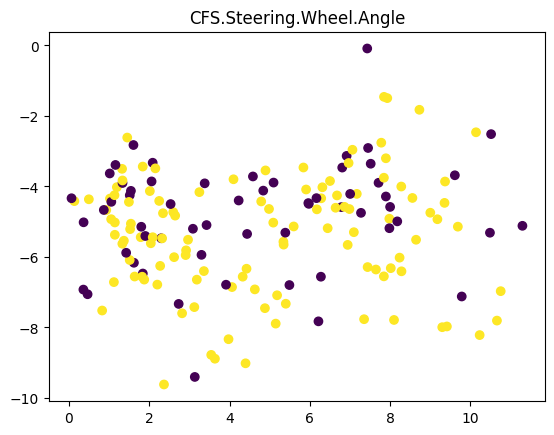

CFS.Steering.Wheel.Angle.Rate


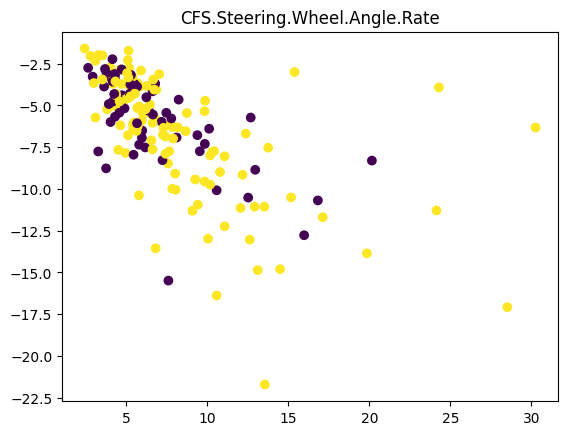

SCC.Lane.Deviation.2


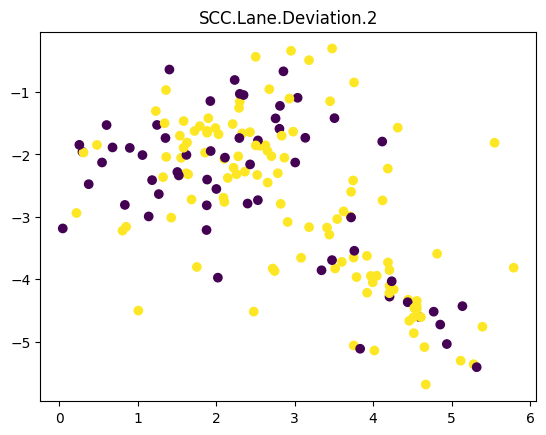

VDS.Veh.Speed


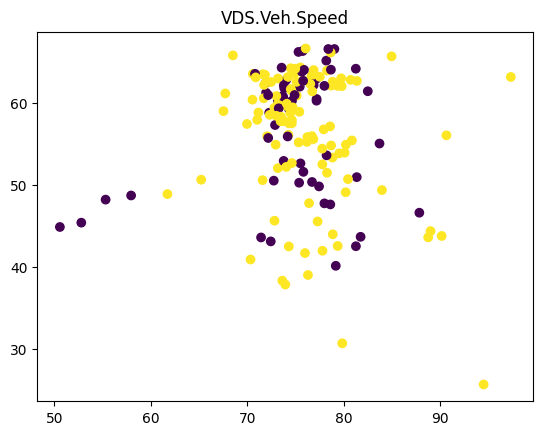

In [92]:
import matplotlib.pyplot as plt

my_vars = ['Full_Sample_ID', 'CFS.Brake.Pedal.Force', 'CFS.Accelerator.Pedal.Position', 'CFS.Steering.Wheel.Angle', 'CFS.Steering.Wheel.Angle.Rate', 'SCC.Lane.Deviation.2', 'VDS.Veh.Speed']
max1s_ch = dd[my_vars].groupby('Full_Sample_ID').rolling(window = 60, min_periods = 1).mean().groupby('Full_Sample_ID').max()
min1s_ch = dd[my_vars].groupby('Full_Sample_ID').rolling(window = 60, min_periods = 1).mean().groupby('Full_Sample_ID').min()
dd_X = pd.concat([max1s_ch.rename(columns={'CFS.Brake.Pedal.Force': 'CFS.Brake.Pedal.Force.Max', 'CFS.Accelerator.Pedal.Position': 'CFS.Accelerator.Pedal.Position.Max', 'CFS.Steering.Wheel.Angle': 'CFS.Steering.Wheel.Angle.Max', 'CFS.Steering.Wheel.Angle.Rate': 'CFS.Steering.Wheel.Angle.Rate.Max', 'SCC.Lane.Deviation.2': 'SCC.Lane.Deviation.2.Max', 'VDS.Veh.Speed': 'VDS.Veh.Speed.Max'}),
                     min1s_ch.rename(columns={'CFS.Brake.Pedal.Force': 'CFS.Brake.Pedal.Force.Min', 'CFS.Accelerator.Pedal.Position': 'CFS.Accelerator.Pedal.Position.Min', 'CFS.Steering.Wheel.Angle': 'CFS.Steering.Wheel.Angle.Min', 'CFS.Steering.Wheel.Angle.Rate': 'CFS.Steering.Wheel.Angle.Rate.Min', 'SCC.Lane.Deviation.2': 'SCC.Lane.Deviation.2.Min', 'VDS.Veh.Speed': 'VDS.Veh.Speed.Min'})],
                     axis=1)

dd_X = dd_X.reset_index()

dd_y = dd.groupby('Full_Sample_ID').first()['Target']
dd_y = dd_y.reset_index()
dd_y = dd_y.drop('Full_Sample_ID', axis=1)

for cur_var in my_vars:
    print(cur_var)
    if cur_var == 'Full_Sample_ID':
        continue
    plt.scatter(dd_X[f"{cur_var}.Max"], dd_X[f"{cur_var}.Min"], c=dd_y['Target'])
    plt.title(cur_var)
    plt.show()

Full_Sample_ID
CFS.Brake.Pedal.Force


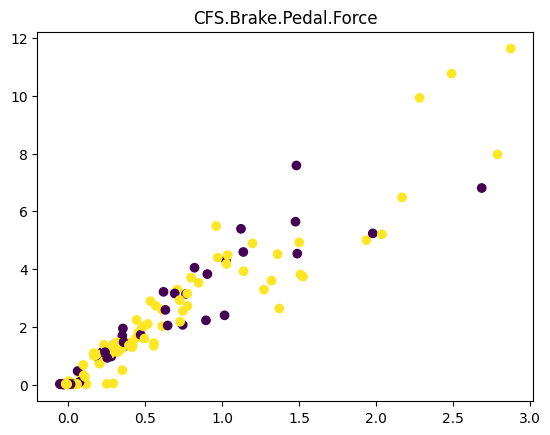

CFS.Accelerator.Pedal.Position


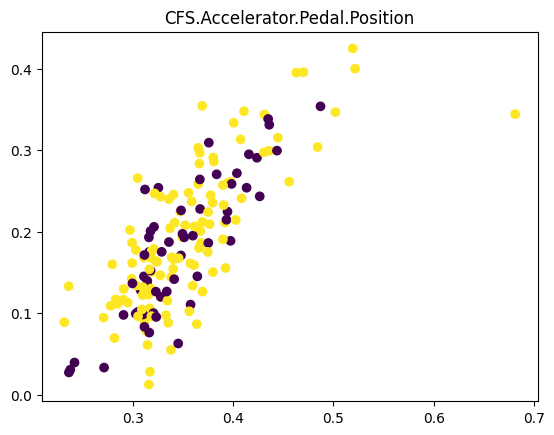

CFS.Steering.Wheel.Angle


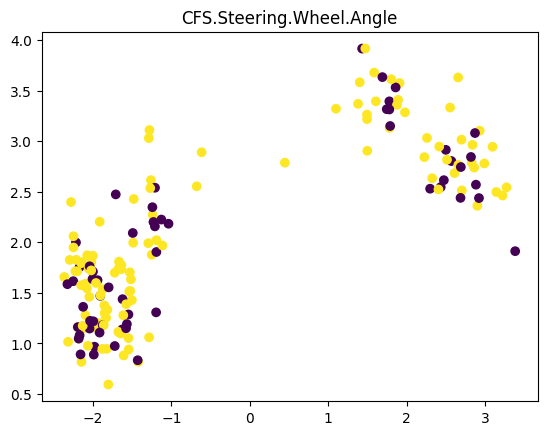

CFS.Steering.Wheel.Angle.Rate


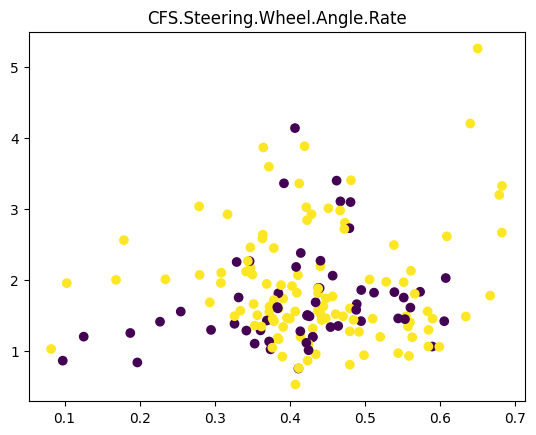

SCC.Lane.Deviation.2


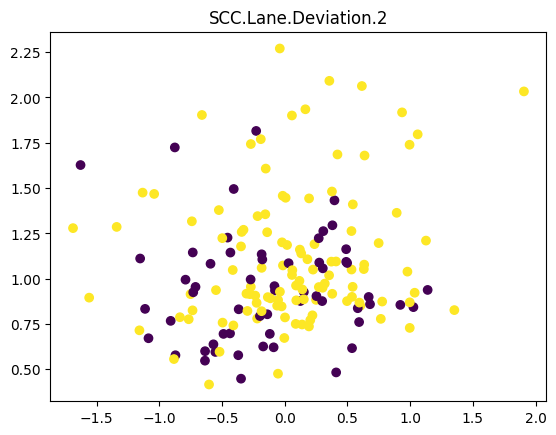

VDS.Veh.Speed


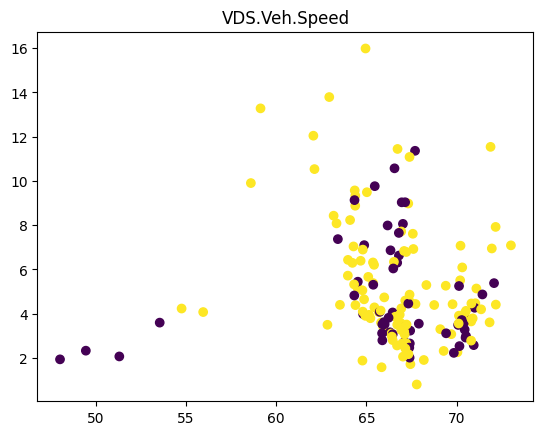

In [93]:
import matplotlib.pyplot as plt

my_vars = ['Full_Sample_ID', 'CFS.Brake.Pedal.Force', 'CFS.Accelerator.Pedal.Position', 'CFS.Steering.Wheel.Angle', 'CFS.Steering.Wheel.Angle.Rate', 'SCC.Lane.Deviation.2', 'VDS.Veh.Speed']
mean1s_ch = dd[my_vars].groupby('Full_Sample_ID').rolling(window = 60, min_periods = 1).mean().groupby('Full_Sample_ID').mean()
std1s_ch = dd[my_vars].groupby('Full_Sample_ID').rolling(window = 60, min_periods = 1).mean().groupby('Full_Sample_ID').std()
dd_X = pd.concat([mean1s_ch.rename(columns={'CFS.Brake.Pedal.Force': 'CFS.Brake.Pedal.Force.Mean', 'CFS.Accelerator.Pedal.Position': 'CFS.Accelerator.Pedal.Position.Mean', 'CFS.Steering.Wheel.Angle': 'CFS.Steering.Wheel.Angle.Mean', 'CFS.Steering.Wheel.Angle.Rate': 'CFS.Steering.Wheel.Angle.Rate.Mean', 'SCC.Lane.Deviation.2': 'SCC.Lane.Deviation.2.Mean', 'VDS.Veh.Speed': 'VDS.Veh.Speed.Mean'}),
                     std1s_ch.rename(columns={'CFS.Brake.Pedal.Force': 'CFS.Brake.Pedal.Force.Std', 'CFS.Accelerator.Pedal.Position': 'CFS.Accelerator.Pedal.Position.Std', 'CFS.Steering.Wheel.Angle': 'CFS.Steering.Wheel.Angle.Std', 'CFS.Steering.Wheel.Angle.Rate': 'CFS.Steering.Wheel.Angle.Rate.Std', 'SCC.Lane.Deviation.2': 'SCC.Lane.Deviation.2.Std', 'VDS.Veh.Speed': 'VDS.Veh.Speed.Std'})],
                     axis=1)

dd_X = dd_X.reset_index()

dd_y = dd.groupby('Full_Sample_ID').first()['Target']
dd_y = dd_y.reset_index()
dd_y = dd_y.drop('Full_Sample_ID', axis=1)

for cur_var in my_vars:
    print(cur_var)
    if cur_var == 'Full_Sample_ID':
        continue
    plt.scatter(dd_X[f"{cur_var}.Mean"], dd_X[f"{cur_var}.Std"], c=dd_y['Target'])
    plt.title(cur_var)
    plt.show()

In [94]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
}
pipe = Pipeline([
    ('model', RandomForestClassifier(min_samples_split=2, min_samples_leaf=1, n_estimators=200, random_state=42, max_depth=20))
])


dd_X = dd_X.drop('Full_Sample_ID', axis=1)
grid = GridSearchCV(pipe, param_grid, scoring='f1', cv=5)
grid.fit(dd_X, dd_y)

print("Best estimator:", grid.best_estimator_)
print("Best cross-validated F1 score:", grid.best_score_)

/Users/muhammadkhalid/Desktop/f2025/STA395/intro/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/muhammadkhalid/Desktop/f2025/STA395/intro/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/muhammadkhalid/Desktop/f2025/STA395/intro/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/muhammadkhalid/Desktop/f2025/STA395/intro/.venv/lib/python3.11/sit

Best estimator: Pipeline(steps=[('model',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2,
                                        n_estimators=200, random_state=42))])
Best cross-validated F1 score: 0.7831519109820996


/Users/muhammadkhalid/Desktop/f2025/STA395/intro/.venv/lib/python3.11/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
